### File descriptions
__train__ - Training set. 10 days of click-through data, ordered chronologically. Non-clicks and clicks are subsampled according to  different strategies.  
__test__ - Test set. 1 day of ads to for testing your model predictions.  
__sampleSubmission.csv__ - Sample submission file in the correct format, corresponds to the All-0.5 Benchmark.

### Data fields
__id__: ad identifier  
__click__: 0/1 for non-click/click  
__hour__: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.  
__C1__ -- anonymized categorical variable  
__banner_pos__  
__site_id__  
__site_domain__  
__site_category__  
__app_id__  
__app_domain__  
__app_category__  
__device_id__  
__device_ip__  
__device_model__  
__device_type__  
__device_conn_type__  
__C14-C21__ -- anonymized categorical variables  

data : https://www.kaggle.com/c/avazu-ctr-prediction/data  
Reference :  
>>https://lsjsj92.tistory.com/    
https://mlwave.com/kaggle-ensembling-guide/    
https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import gzip
import random

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,roc_curve, accuracy_score, classification_report,confusion_matrix
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [3]:
random.seed(1111)
num_lines = 40428968 - 1# train.gz file lines counting
sample_size = 1000000
skip = sorted(random.sample(range(1, num_lines), num_lines-sample_size))
skip[0]
# skip = skip[1:] # if contains index=0, the header will be removed

1

In [4]:
train_path = "./Downloads/avazu-ctr-prediction/train.csv"
# skip = sorted(random.sample(range(num_lines), num_lines-sample_size))
train_df = pd.read_csv(
    train_path, 
    header=0,
    skiprows=skip)
print(len(train_df))

train_df.head()

1000000


,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000724729988544911,0,14102100,1005,0,8fda644b,25d4cfcd,f028772b,ecad2386,7801e8d9,...,1,0,20362,320,50,2333,0,39,-1,157
1,10005249248600843539,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100083,79
2,10009190848778773294,0,14102100,1005,1,5ee41ff2,17d996e6,f028772b,ecad2386,7801e8d9,...,1,0,16920,320,50,1899,0,431,-1,117
3,10010966574628106108,1,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,0acbeaa3,45a51db4,...,1,0,20596,320,50,2161,0,35,100034,157
4,10011406079394798455,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,1,0,20362,320,50,2333,0,39,-1,157


In [5]:
train_df.tail()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
999995,9949359116589603714,1,14103023,1005,0,5b08c53b,7687a86e,3e814130,ecad2386,7801e8d9,...,1,0,17653,300,250,1994,2,39,-1,33
999996,99743655757035871,0,14103023,1005,0,85f751fd,c4e18dd6,50e219e0,396df801,2347f47a,...,1,0,23723,320,50,2716,3,47,-1,23
999997,9992484712417106617,0,14103023,1005,0,d6137915,bb1ef334,f028772b,ecad2386,7801e8d9,...,1,0,19771,320,50,2227,0,935,-1,48
999998,9994670492261359346,1,14103023,1005,1,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,...,1,0,17753,320,50,1993,2,1063,-1,33
999999,9999746639881208566,0,14103023,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,22257,320,50,2545,0,431,100084,221


In [6]:
train_df.shape 

(1000000, 24)

In [7]:
train_df.isna().sum() #NaN checking

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

In [8]:
sum(train_df.duplicated()) #checking duplication

0

In [9]:
train_df.corr()

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
id,1.000000,-0.000770,0.001826,0.000509,0.000220,-0.000480,-0.000274,-0.000603,-0.000575,-0.000200,-0.000536,-0.000314,0.001552,-0.000137,-0.000523
click,-0.000770,1.000000,-0.009408,-0.037081,0.024840,-0.037736,-0.083609,-0.060337,-0.032708,0.131354,-0.055969,0.020790,-0.005533,-0.058258,-0.070130
hour,0.001826,-0.009408,1.000000,-0.003587,0.029163,-0.002794,0.051630,0.197145,0.022736,0.003223,0.187503,0.012328,0.042224,0.025209,0.065799
C1,0.000509,-0.037081,-0.003587,1.000000,0.290149,0.895406,0.198664,0.055747,0.119365,0.064785,0.063962,-0.042252,0.003059,-0.035291,0.035946
banner_pos,0.000220,0.024840,0.029163,0.290149,1.000000,0.325752,-0.080040,-0.010917,0.061145,0.028899,-0.030487,0.094785,0.132037,0.054454,-0.097330
device_type,-0.000480,-0.037736,-0.002794,0.895406,0.325752,1.000000,0.212198,0.044439,0.177696,0.067386,0.050288,-0.047535,-0.002048,-0.048916,0.036974
device_conn_type,-0.000274,-0.083609,0.051630,0.198664,-0.080040,0.212198,1.000000,0.067181,0.068391,-0.013142,0.079763,-0.062555,-0.010597,0.089376,0.062007
C14,-0.000603,-0.060337,0.197145,0.055747,-0.010917,0.044439,0.067181,1.000000,0.002278,0.037775,0.976793,-0.231148,-0.134970,0.024475,0.409663
C15,-0.000575,-0.032708,0.022736,0.119365,0.061145,0.177696,0.068391,0.002278,1.000000,-0.073265,0.000950,0.011403,0.049867,0.009789,0.002252
C16,-0.000200,0.131354,0.003223,0.064785,0.028899,0.067386,-0.013142,0.037775,-0.073265,1.000000,0.048084,0.083726,-0.072690,-0.046676,-0.083657


In [10]:
def to_date_column(df): #making time features
    df["dt_hour"] = pd.to_datetime(df["hour"], format="%y%m%d%H")
    df["year"] = df["dt_hour"].dt.year
    df["month"] = df["dt_hour"].dt.month
    df["day"] = df["dt_hour"].dt.day
    df["int_hour"] = df["dt_hour"].dt.hour
    df["is_weekday"] = df["dt_hour"].dt.dayofweek
    df["is_weekend"] = df.apply(lambda x: x["is_weekday"] in [5, 6], axis=1)

In [11]:
to_date_column(train_df)
train_df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C19,C20,C21,dt_hour,year,month,day,int_hour,is_weekday,is_weekend
0,10000724729988544911,0,14102100,1005,0,8fda644b,25d4cfcd,f028772b,ecad2386,7801e8d9,...,39,-1,157,2014-10-21,2014,10,21,0,1,False
1,10005249248600843539,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,35,100083,79,2014-10-21,2014,10,21,0,1,False
2,10009190848778773294,0,14102100,1005,1,5ee41ff2,17d996e6,f028772b,ecad2386,7801e8d9,...,431,-1,117,2014-10-21,2014,10,21,0,1,False
3,10010966574628106108,1,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,0acbeaa3,45a51db4,...,35,100034,157,2014-10-21,2014,10,21,0,1,False
4,10011406079394798455,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,...,39,-1,157,2014-10-21,2014,10,21,0,1,False


In [12]:
data = train_df.set_index("id") #indexing

In [13]:
 #Label encoding every features
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

d = defaultdict(LabelEncoder)
data = data.apply(lambda x: d[x.name].fit_transform(x))
data.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C19,C20,C21,dt_hour,year,month,day,int_hour,is_weekday,is_weekend
id,,,,,,,,,,,,,,,,,,,,,
10000724729988544911,0,0,2,0,1515,423,18,2929,83,0,...,4,0,42,0,0,0,0,0,1,0
10005249248600843539,0,0,2,0,325,2746,1,2929,83,0,...,2,60,22,0,0,0,0,0,1,0
10009190848778773294,0,0,2,1,1026,242,18,2929,83,0,...,27,0,39,0,0,0,0,0,1,0
10010966574628106108,1,0,2,0,1405,2248,5,137,46,23,...,2,23,42,0,0,0,0,0,1,0
10011406079394798455,0,0,2,0,923,2284,3,2929,83,0,...,4,0,42,0,0,0,0,0,1,0


In [14]:
data.describe()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C19,C20,C21,dt_hour,year,month,day,int_hour,is_weekday,is_weekend
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.169937,118.542594,2.024398,0.287163,1286.926203,1937.871556,8.312936,2545.888205,78.678669,2.901245,...,12.498500,42.543187,21.560770,118.542594,0.0,0.0,4.469194,11.281938,2.600972,0.177993
std,0.375578,71.648652,0.550573,0.494806,661.167447,687.448298,6.833891,740.009647,32.102050,6.055237,...,15.786045,47.591854,17.430149,71.648652,0.0,0.0,2.962651,5.959242,1.728264,0.382507
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,52.000000,2.000000,0.000000,965.000000,1445.000000,3.000000,2596.000000,83.000000,0.000000,...,2.000000,0.000000,6.000000,52.000000,0.0,0.0,2.000000,7.000000,1.000000,0.000000
50%,0.000000,122.000000,2.000000,0.000000,1405.000000,2248.000000,5.000000,2929.000000,83.000000,0.000000,...,4.000000,30.000000,16.000000,122.000000,0.0,0.0,5.000000,11.000000,2.000000,0.000000
75%,0.000000,182.000000,2.000000,1.000000,1405.000000,2248.000000,18.000000,2929.000000,83.000000,3.000000,...,13.000000,68.000000,31.000000,182.000000,0.0,0.0,7.000000,16.000000,4.000000,0.000000
max,1.000000,239.000000,6.000000,6.000000,2690.000000,2893.000000,19.000000,3168.000000,190.000000,24.000000,...,65.000000,160.000000,59.000000,239.000000,0.0,0.0,9.000000,23.000000,6.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015DEF638EB0>,
      dtype=object)

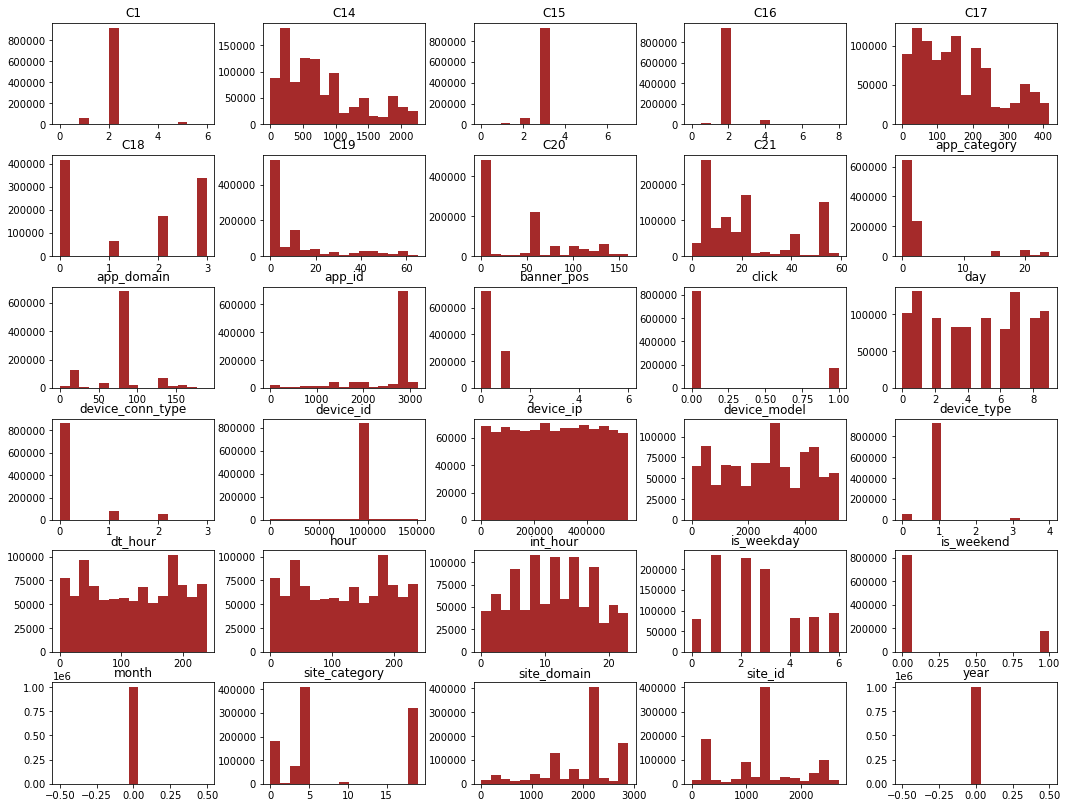

In [15]:
data.hist(bins=15, color='brown', figsize=(18,14), grid=False) #Checking normal distribution

In [16]:
data.drop(['year', 'day', 'month'], axis = 1, inplace =True)

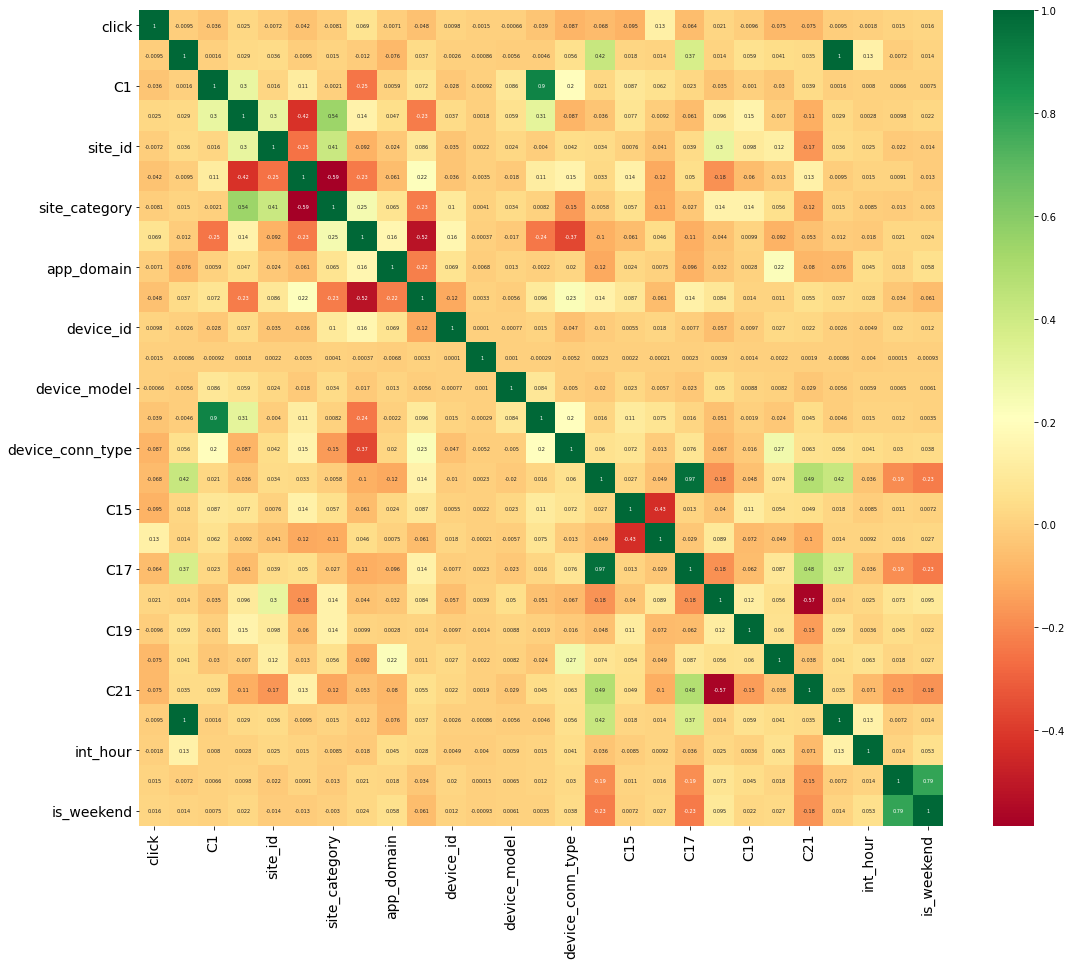

In [17]:
import seaborn as sns
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0,annot_kws={'size':5})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.show()

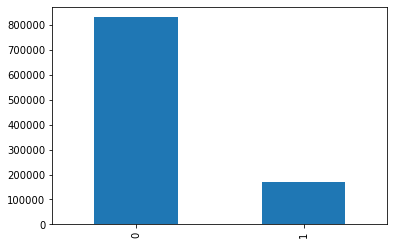

In [18]:
data.iloc[ :, 0].value_counts().plot(kind ='bar') #imbalance checking

In [19]:
data.iloc[:, 0].value_counts() / data.iloc[:, 0].count() * 100 #imbalance ratio checking 

0    83.0063
1    16.9937
Name: click, dtype: float64

In [20]:
submission_df = pd.read_csv("./Downloads/avazu-ctr-prediction/sampleSubmission.gz")


In [21]:
#train data and test data split (75% : 25%)
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedShuffleSplit

X = data.drop('click', axis=1)
y = data['click']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [22]:
def metrics(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    con = confusion_matrix(y_test, pred)
    roc_score = roc_auc_score(y_test, pred, average ='macro')
    
    print('accuracy : {0:2f}, precision : {1:2f}, recall : {2:2f}'.format(accuracy, precision, recall)) 
    print('f1-score : {0:2f}, auc : {1:2f}'.format(f1, roc_score))
    print(con)

In [23]:
def modeling(model, x_train, x_test, y_train, y_test) :
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    metrics(y_test, pred)
    probs = model.predict_proba(x_test)
    probs = probs[:, 1]
    auc = roc_auc_score(y_test, probs)
    print('AUC - Test Set: %.2f%%' % (auc*100))
    
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # show the plot
    plt.show()

accuracy : 0.830140, precision : 0.250000, recall : 0.000047
f1-score : 0.000094, auc : 0.500009
[[207533      6]
 [ 42459      2]]
AUC - Test Set: 56.79%


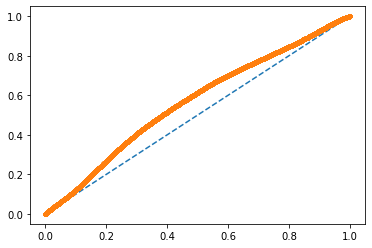

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
modeling(lr,X_train, X_test, y_train, y_test)

accuracy : 0.833884, precision : 0.574488, recall : 0.084642
f1-score : 0.147546, auc : 0.535908
[[204877   2662]
 [ 38867   3594]]
AUC - Test Set: 74.32%


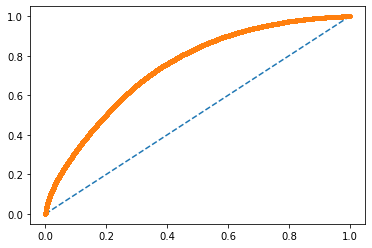

24.480685234069824


In [25]:
from lightgbm import LGBMClassifier
import time
start = time.time() 
lgb = LGBMClassifier(n_estimators = 1500, num_leaves = 64, n_jobs = -1, reg_alpha = 0.9, reg_lambda = 0.2, boost_from_average = False)
modeling(lgb,x_train = X_train, x_test = X_test, y_train = y_train, y_test = y_test)
print(time.time()-start)

[09:53:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy : 0.832352, precision : 0.587393, recall : 0.043452
f1-score : 0.080918, auc : 0.518604
[[206243   1296]
 [ 40616   1845]]
AUC - Test Set: 73.02%


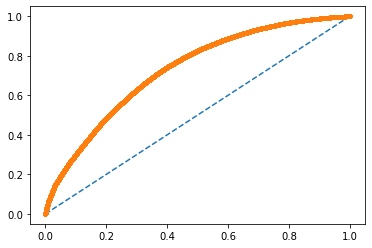

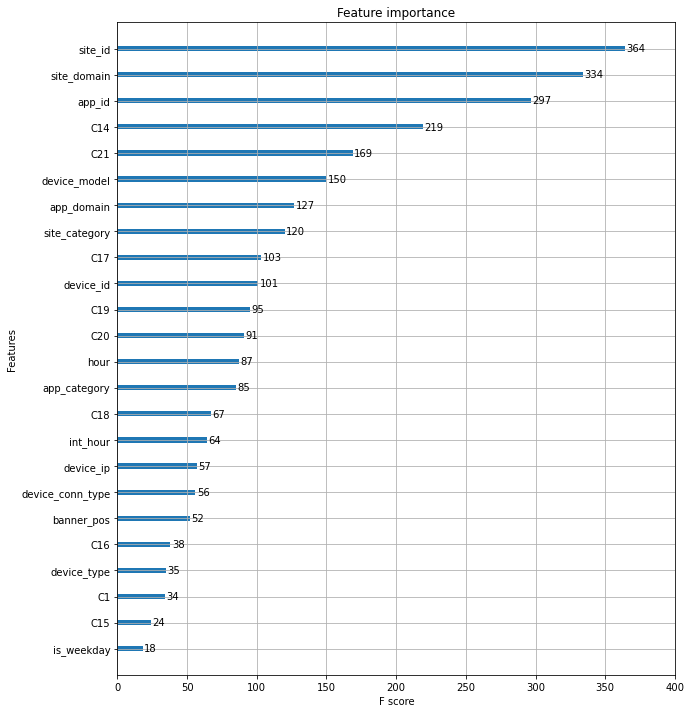

In [27]:
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

xgb = XGBClassifier(n_estimators=400, learning_rate = 0.1,max_depth = 3)
modeling(xgb,x_train = X_train, x_test = X_test, y_train = y_train, y_test = y_test )
fix,ax = plt.subplots(figsize = (10, 12))
plot_importance(xgb, ax = ax)
plt.show()

#### Every evaluation of index is low except the accuracy. It is because the imbalance of predict values.  
#### I import imblearn to make a balanced dataset

In [34]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0) 
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)
print('Features/labels dataset before SMOTE: ', X_train.shape, y_train.shape) 
print('Features/labels dataset after SMOTE: ', X_train_over.shape, y_train_over.shape)
print('Distribution of SMOTE: \n', pd.Series(y_train_over).value_counts())

Features/labels dataset before SMOTE:  (750000, 26) (750000,)
Features/labels dataset after SMOTE:  (1245048, 26) (1245048,)
Distribution of SMOTE: 
 1    622524
0    622524
Name: click, dtype: int64


accuracy : 0.534308, precision : 0.206323, recall : 0.611879
f1-score : 0.308590, auc : 0.565158
[[107596  99943]
 [ 16480  25981]]
AUC - Test Set: 58.75%


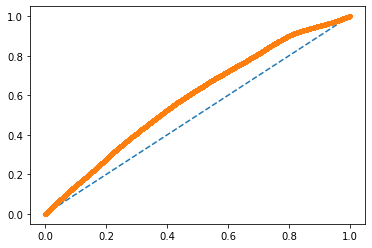

In [35]:
lr = LogisticRegression()
modeling(lr,X_train_over, X_test, y_train_over, y_test)

accuracy : 0.829888, precision : 0.496512, recall : 0.112315
f1-score : 0.183191, auc : 0.544507
[[202703   4836]
 [ 37692   4769]]
AUC - Test Set: 73.43%


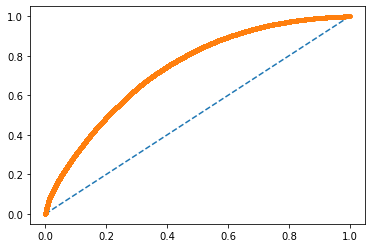

In [36]:
lgb = LGBMClassifier(n_estimators = 1500, num_leaves = 64, n_jobs = -1, reg_alpha = 0.9, reg_lambda = 0.2, boost_from_average = True)
modeling(lgb,x_train = X_train_over, x_test = X_test, y_train = y_train_over, y_test = y_test)

[12:33:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy : 0.804892, precision : 0.357324, recall : 0.186265
f1-score : 0.244880, auc : 0.558862
[[193314  14225]
 [ 34552   7909]]
AUC - Test Set: 68.47%


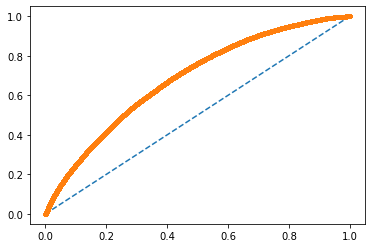

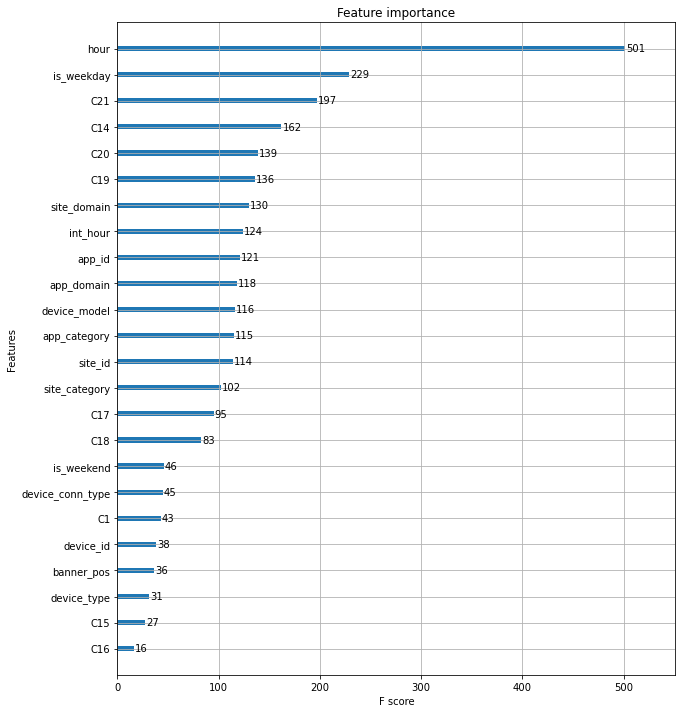

In [37]:
xgb = XGBClassifier(n_estimators=400, learning_rate = 0.1,max_depth = 3)
modeling(xgb,x_train = X_train_over, x_test = X_test, y_train = y_train_over, y_test = y_test )
fix,ax = plt.subplots(figsize = (10, 12))
plot_importance(xgb, ax = ax)
plt.show()